In [39]:
import pandas as pd
import matplotlib.pyplot as plt
from clickhouse_driver import Client
from datetime import datetime




In [40]:

client = Client(host='localhost', user='Harsh', password='Harsh@12')

In [41]:
def best_country():
    query = """
    SELECT 
        SUM(ib.sales) AS profit, 
        ib.country,
        AVG(ib.monthly_rent) AS avg_rent 
    FROM icecream_business ib 
    JOIN weather_3hourly_simple whs 
        ON ib.country = whs.country 
    GROUP BY country 
    ORDER BY profit DESC, avg_rent ASC
    """
    # Correct column order to match query output
    return pd.DataFrame(client.execute(query), columns=["profit", "country", "avg_rent"])

# Fetch and display
df = best_country()
display(df.head())


,profit,country,avg_rent
0,856800,IT,1550.0
1,688800,FR,1600.0
2,520800,DE,1400.0
3,436800,GB,1500.0


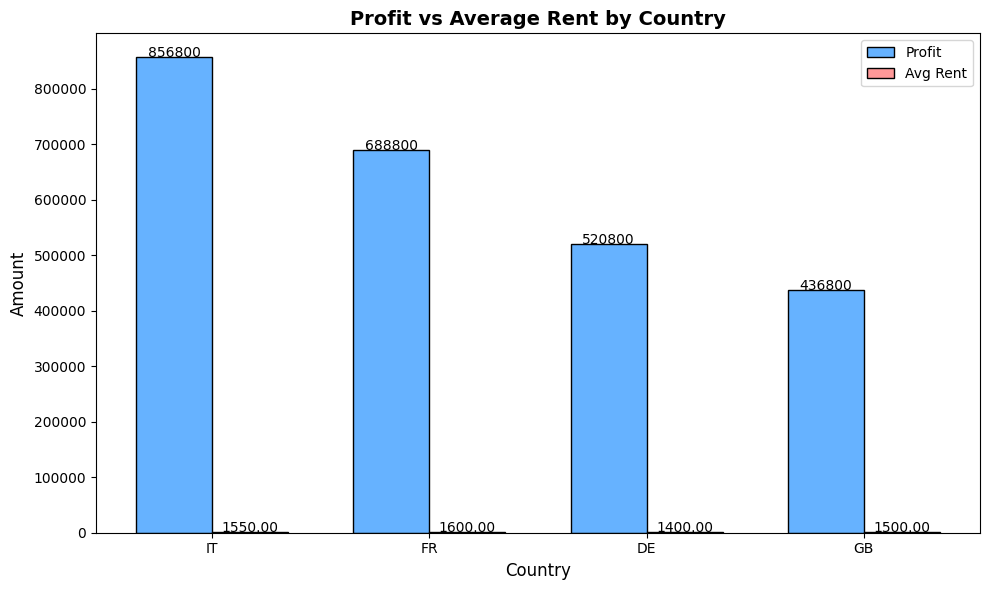

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Fetch the data
df = best_country()

# --- Prepare for grouped bar chart ---
countries = df["country"]
profit = df["profit"]
avg_rent = df["avg_rent"]

x = np.arange(len(countries))  # the label locations
width = 0.35  # the width of the bars

plt.figure(figsize=(10,6))

# Plot bars
plt.bar(x - width/2, profit, width, label="Profit", color="#66B2FF", edgecolor="black")
plt.bar(x + width/2, avg_rent, width, label="Avg Rent", color="#FF9999", edgecolor="black")

# Labels & Title
plt.xlabel("Country", fontsize=12)
plt.ylabel("Amount", fontsize=12)
plt.title("Profit vs Average Rent by Country", fontsize=14, fontweight="bold")
plt.xticks(x, countries)

# Show values on top of bars
for i in range(len(countries)):
    plt.text(x[i] - width/2, profit[i] + 10, f"{profit[i]:.0f}", ha='center', fontsize=10)
    plt.text(x[i] + width/2, avg_rent[i] + 0.5, f"{avg_rent[i]:.2f}", ha='center', fontsize=10)

plt.legend()
plt.tight_layout()
plt.show()


,month,rev,rent,country
0,9,40622400.0,14112000,DE
1,9,30996000.0,16128000,FR
2,9,23150400.0,15120000,GB
3,9,39412800.0,15624000,IT


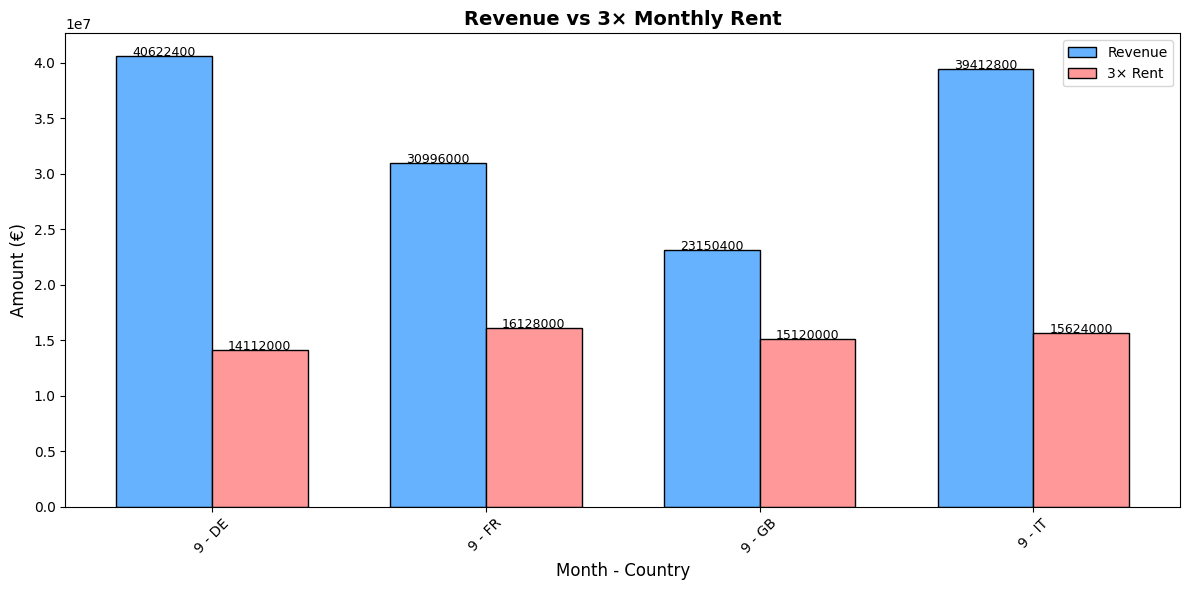

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Query function ---
def revenue_vs_rent():
    query = """
    SELECT 
        toMonth(whs.timestamp_utc) AS month, 
        SUM(ib.sales * ib.ice_cream_price) AS rev, 
        3 * SUM(ib.monthly_rent) AS rent,
        ib.country
    FROM icecream_business ib
    JOIN weather_3hourly_simple whs
        ON ib.country = whs.country
    GROUP BY month, country
    HAVING rev > rent
    ORDER BY month, country
    """
    return pd.DataFrame(client.execute(query), columns=["month", "rev", "rent", "country"])

# Fetch data
df = revenue_vs_rent()
display(df.head())

# --- Plot grouped bar chart ---
months = df["month"].astype(str) + " - " + df["country"]  # x-axis labels: month-country
rev = df["rev"]
rent = df["rent"]
x = np.arange(len(months))
width = 0.35

plt.figure(figsize=(12,6))
plt.bar(x - width/2, rev, width, label="Revenue", color="#66B2FF", edgecolor="black")
plt.bar(x + width/2, rent, width, label="3× Rent", color="#FF9999", edgecolor="black")

plt.xlabel("Month - Country", fontsize=12)
plt.ylabel("Amount (€)", fontsize=12)
plt.title("Revenue vs 3× Monthly Rent", fontsize=14, fontweight="bold")
plt.xticks(x, months, rotation=45)

# Show values on top of bars
for i in range(len(months)):
    plt.text(x[i] - width/2, rev[i] + 5, f"{rev[i]:.0f}", ha='center', fontsize=9)
    plt.text(x[i] + width/2, rent[i] + 5, f"{rent[i]:.0f}", ha='center', fontsize=9)

plt.legend()
plt.tight_layout()
plt.show()


,roi,country
0,35912520.0,DE
1,34198752.0,IT
2,25613616.0,FR
3,18104184.0,GB


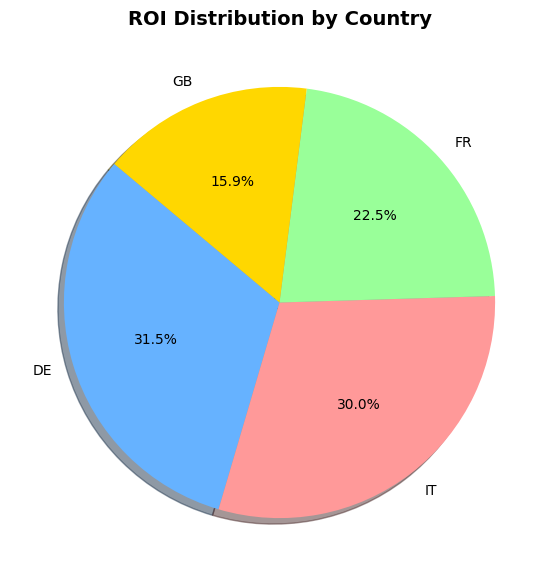

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Query function ---
def roi_per_country():
    query = """
    SELECT 
        ROUND(SUM(ib.sales * ib.ice_cream_price) - (SUM(ib.diesel_price + ib.monthly_rent)), 2) AS roi,
        ib.country
    FROM icecream_business ib
    JOIN weather_3hourly_simple whs
        ON ib.country = whs.country
    GROUP BY ib.country
    ORDER BY roi DESC
    """
    return pd.DataFrame(client.execute(query), columns=["roi", "country"])

# Fetch data
df = roi_per_country()
display(df)

# --- Plot Pie Chart ---
plt.figure(figsize=(7,7))
colors = ["#66B2FF", "#FF9999", "#99FF99", "#FFD700"]  # Optional: distinct colors for each country
plt.pie(df["roi"], labels=df["country"], autopct="%1.1f%%", startangle=140, colors=colors, shadow=True)
plt.title("ROI Distribution by Country", fontsize=14, fontweight="bold")
plt.show()


,city,corr_temp,corr_humidity,corr_wind
0,London,1.0,-1.0,-1.0
1,Rome,1.0,1.0,1.0
2,Berlin,1.0,-1.0,-1.0
3,Paris,NaN,NaN,NaN


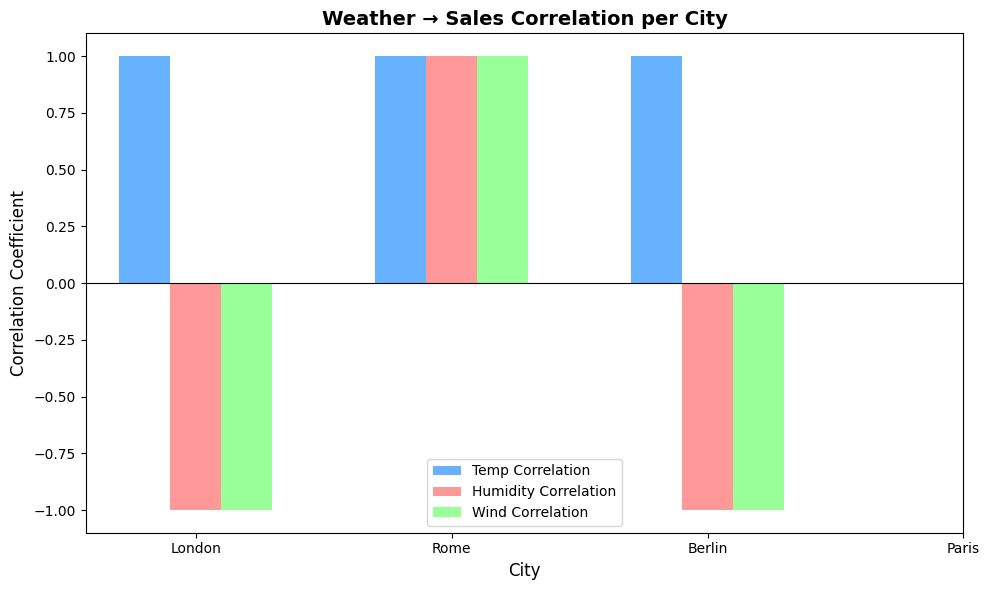

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Query function ---
def weather_sales_corr():
    query = """
    WITH cte AS (
        SELECT
            ib.city,
            ib.country,
            toDate(ib.date) AS day,
            SUM(ib.sales) AS daily_sales,
            AVG(w.temp) AS avg_temp,
            AVG(w.humidity) AS avg_humidity,
            AVG(w.wind_speed) AS avg_wind
        FROM icecream_business AS ib
        JOIN weather_3hourly_simple AS w
            ON ib.city = w.city
           AND toDate(w.timestamp_utc) = toDate(ib.date)
        GROUP BY ib.city, ib.country, day
    )
    SELECT
        city,
        corr(daily_sales, avg_temp) AS corr_temp,
        corr(daily_sales, avg_humidity) AS corr_humidity,
        corr(daily_sales, avg_wind) AS corr_wind
    FROM cte
    GROUP BY city
    """
    return pd.DataFrame(client.execute(query), columns=["city", "corr_temp", "corr_humidity", "corr_wind"])

# Fetch data
df = weather_sales_corr()
display(df)

# --- Plot grouped bar chart ---
cities = df["city"]
x = np.arange(len(cities))
width = 0.2

plt.figure(figsize=(10,6))
plt.bar(x - width, df["corr_temp"], width, label="Temp Correlation", color="#66B2FF")
plt.bar(x, df["corr_humidity"], width, label="Humidity Correlation", color="#FF9999")
plt.bar(x + width, df["corr_wind"], width, label="Wind Correlation", color="#99FF99")

plt.xlabel("City", fontsize=12)
plt.ylabel("Correlation Coefficient", fontsize=12)
plt.title("Weather → Sales Correlation per City", fontsize=14, fontweight="bold")
plt.xticks(x, cities)

plt.axhline(0, color='black', linewidth=0.8)  # Reference line at 0
plt.legend()
plt.tight_layout()
plt.show()


,day,country,rolling_profit
0,2025-09-05,DE,514912.5
1,2025-09-06,DE,1135294.5
2,2025-09-04,FR,274431.6
3,2025-09-04,GB,87446.7
4,2025-09-05,GB,383354.2


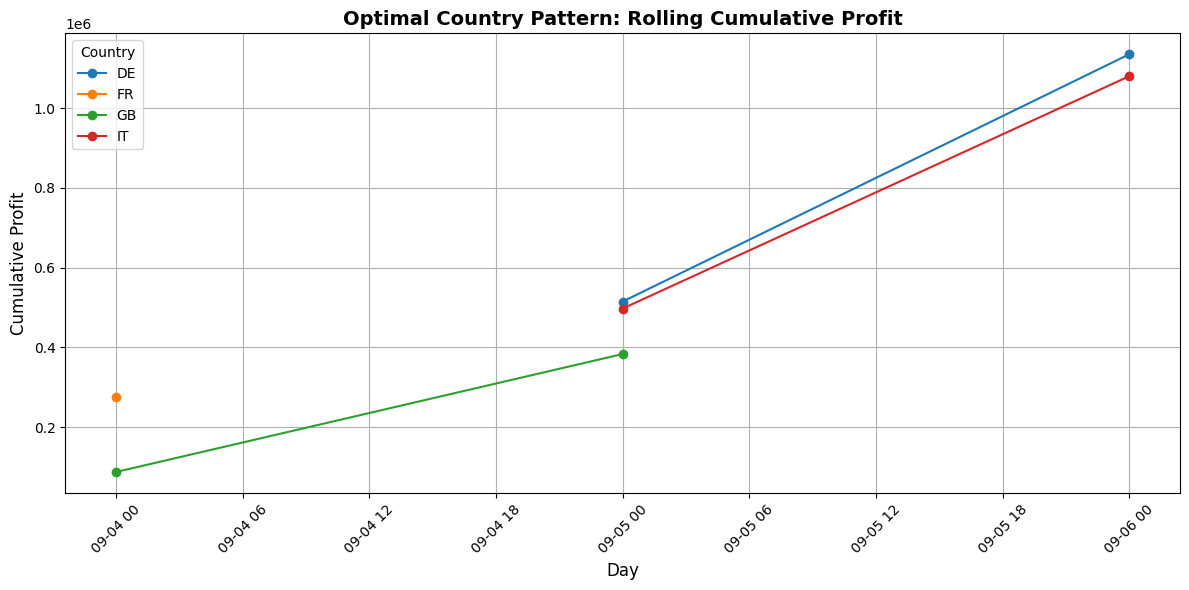

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Query function ---
def optimal_country_pattern():
    query = """
    WITH cte AS (
        SELECT 
            ROUND(SUM(ib.sales * ib.ice_cream_price) - (SUM(ib.diesel_price + ib.monthly_rent)), 2) AS profit,
            ib.country,
            DATE(ib.date) AS day
        FROM icecream_business ib
        JOIN weather_3hourly_simple whs
            ON ib.country = whs.country
           AND DATE(ib.date) = DATE(whs.timestamp_utc)
        GROUP BY ib.country, day
    )
    SELECT 
        day,
        country,
        SUM(profit) OVER (PARTITION BY country ORDER BY day) AS rolling_profit
    FROM cte
    ORDER BY country, day
    """
    return pd.DataFrame(client.execute(query), columns=["day", "country", "rolling_profit"])

# Fetch data
df = optimal_country_pattern()
display(df.head())

# --- Plot Multi-Line Chart ---
plt.figure(figsize=(12,6))

for country in df['country'].unique():
    country_data = df[df['country'] == country]
    plt.plot(country_data['day'], country_data['rolling_profit'], marker='o', label=country)

plt.xlabel("Day", fontsize=12)
plt.ylabel("Cumulative Profit", fontsize=12)
plt.title("Optimal Country Pattern: Rolling Cumulative Profit", fontsize=14, fontweight="bold")
plt.legend(title="Country")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
